# Chapter 4: Exceptional Return, Benchmarks, and Value Added

## Summary
 - The components of expected return are defined
    > _Exceptional expected return is the difference between our forecasts and the consensus_
 - Benchmark portfolios are a standard for the active manager
 - Active management value-added is expected exceptional return less a penalty for active variance
 - Management of total risk and return is distinct from management of active risk and return
 - Benchmark timing decisions are distinct from stock selection decisions


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

## From Market to Benchmark
We replace notion of **market** with **benchmark** reusing the same machinery from CAPM
$$\boxed{ \beta_{n} = r_{n} = \frac{\text{Cov}(r_{n},r_{B})}{\text{Var}(r_{B})} }$$

## Components of Expected Return
$$\boxed{ E\{R_{n}\} = 1 + i_{f} + \beta _{n} \cdot \mu_{B} + \beta_{n} \cdot \Delta f_{B} + \alpha_{n} }$$
- **The Time Premium:** &emsp; $i_{f}$
 > The return an investor receives for parting with the investment stake for a year
- **The Risk Premium:**  &emsp; $\beta _{n} \cdot \mu_{B}$
 > The expected excess return on a benchmark $\mu_{B}$ is usually estimated over very long run (70+ years) 3-7% for equity markets
- **Exceptional Benchmark Return:**  &emsp; $\beta_{n} \cdot \Delta f_{B}$
 > $\Delta f_{B}$ is your measure of the difference between expected long run excess return and that of the near future
- **Alpha:**  &emsp; $\alpha_{n}$
 > Alpha is the expected residual return $\alpha_{n} = E\{\theta_{n}\}$
***
- **Consensus Expected Return:** &emsp; ${ \beta_{n} \cdot \mu_{B}} $
 > The consensus expected return is the expected excess return ontain if one accepts the benchmark as ex ante with expected excess return $\mu_{B}$
- **Expected Excess Return:** &emsp; ${ f_{n} = \beta_{n} \cdot \mu_{B} + \beta_{n} \cdot \Delta f_{B} + \alpha_{n} } $
> The expected excess return $f_{n}$ composes risk premium, exceptional benchmark forecast and alpha
- **Exception Excess Return:** &emsp; ${ \beta_{n} \cdot \Delta f_{B} + \alpha_{n} } $
> This is the **key** to **_active management_**.  It composes of benchmark timing _(exceptional benchmark return)_ and stock selection _(alpha)_

## Management of Total Risk and Return


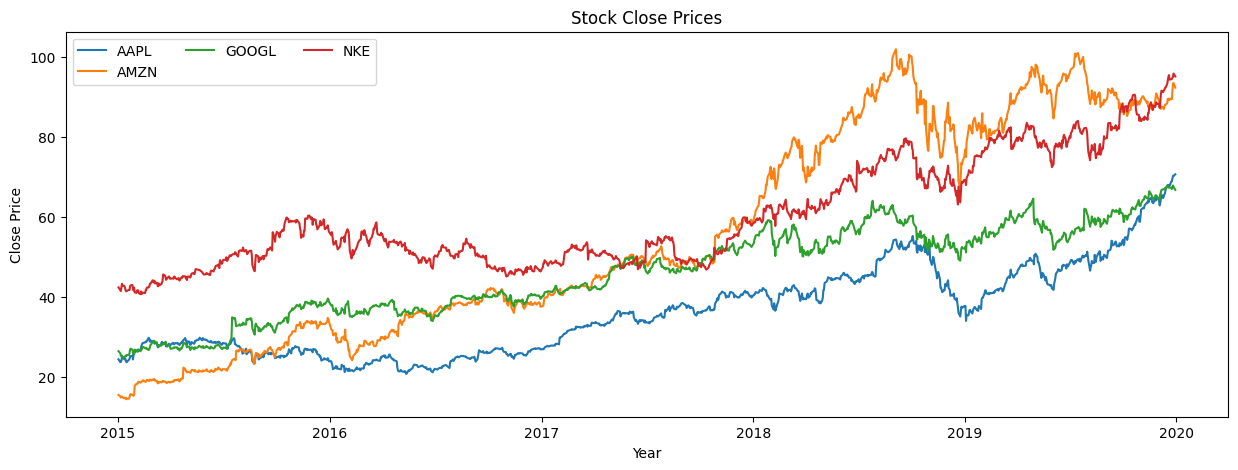

In [2]:
# adapted from:
# https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/
# https://medium.com/@zeng.simonl/the-efficient-frontier-in-python-a1bc9496a0a1
# https://www.kaggle.com/code/achrafbenssassi/portfolio-optimization-using-efficient-frontier

START = "2015-01-01"
END = "2019-12-31"

#stock_list = ['BA', 'AMD'] # ['ACN', 'BA', 'BAC', 'CAT', 'HP', 'INTC', 'KMB', 'NVDA', 'AAL', 'XRX']
stock_list = ['AAPL', 'NKE', 'GOOGL', 'AMZN']
stocks = yf.download(stock_list, start=START, end=END, progress=False)
stocks = stocks['Close']
log_returns = np.log(stocks/stocks.shift(1)).iloc[1:]

plt.figure(figsize=(15, 5))
handles = plt.plot(stocks, label='Close Price')
plt.title('Stock Close Prices')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.legend(handles=handles, labels=list(stocks.columns), ncol=3)
plt.show()

Average Returns

In [3]:
# Mean
log_returns.mean() * 250

Ticker
AAPL     0.212063
AMZN     0.356185
GOOGL    0.184749
NKE      0.161141
dtype: float64

Covariance

In [4]:
# Covariance (display yearly)
stocks_cov = log_returns.cov()
stocks_cov * 250

Ticker,AAPL,AMZN,GOOGL,NKE
Ticker,,,,
AAPL,0.061440,0.035550,0.030623,0.020922
AMZN,0.035550,0.083388,0.044040,0.023071
GOOGL,0.030623,0.044040,0.055401,0.021333
NKE,0.020922,0.023071,0.021333,0.054717


Correlations

In [5]:
# Correlations
stocks_corr = log_returns.corr()
stocks_corr

Ticker,AAPL,AMZN,GOOGL,NKE
Ticker,,,,
AAPL,1.000000,0.496660,0.524876,0.360850
AMZN,0.496660,1.000000,0.647941,0.341554
GOOGL,0.524876,0.647941,1.000000,0.387465
NKE,0.360850,0.341554,0.387465,1.000000


Portfolio Variance

We weight the portfolio according to some criteria


In [6]:
# add some 'random' variance to the portfolio
portfolio_weights = {'AAPL': 0.1, 'NKE': 0.2, 'GOOGL': 0.5, 'AMZN': 0.2}
port_var = stocks_cov.mul(portfolio_weights, axis=0).mul(portfolio_weights, axis=1).sum().sum()
port_var

np.float64(0.00016092126039759247)

Portfolio expected returns

- resample ('YE') to calculate yearly returns on each stock in the portfolio
- calculate the volatility in the usual fashion (log of returns)

In [7]:
ind_er = stocks.resample('YE').last().pct_change().mean()
ind_er

Ticker
AAPL     0.357854
AMZN     0.295745
GOOGL    0.155478
NKE      0.160666
dtype: float64

In [8]:
sorted_weights = dict(sorted(portfolio_weights.items()))
port_er = (list(sorted_weights.values())*ind_er).sum()
port_er

np.float64(0.20480655540235132)

In [9]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = stocks.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

Ticker
AAPL     0.247871
AMZN     0.288770
GOOGL    0.235375
NKE      0.233916
dtype: float64

In [10]:
# Creating a table for visualising returns and volatility of assets
assets = pd.concat([ind_er, ann_sd], axis=1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
Ticker,,
AAPL,0.357854,0.247871
AMZN,0.295745,0.288770
GOOGL,0.155478,0.235375
NKE,0.160666,0.233916


Efficient Frontier

Plot the efficient frontier for the portfolio ('returns') on y-axis and volatility on the x-axis.  Shows the maximum return we can obtain for a set level of volatility or conversely the volatility we need to accept for a given level of returns.

As you can see this is a pretty risky portfolio, with high minimum volatility and conversely large returns!

In [11]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(stocks.columns)
num_portfolios = 10_000

for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its weights
    p_ret.append(returns)
    var = stocks_cov.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(stocks.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

portfolios  = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,AAPL weight,AMZN weight,GOOGL weight,NKE weight
0,0.216224,0.199180,0.078681,0.299279,0.073908,0.548132
1,0.231871,0.190436,0.221888,0.211486,0.215050,0.351576
2,0.196089,0.192822,0.149116,0.064288,0.513687,0.272909
3,0.223742,0.199261,0.092376,0.335278,0.082556,0.489791
4,0.247199,0.191620,0.366929,0.107144,0.056721,0.469207


<Axes: xlabel='Volatility', ylabel='Returns'>

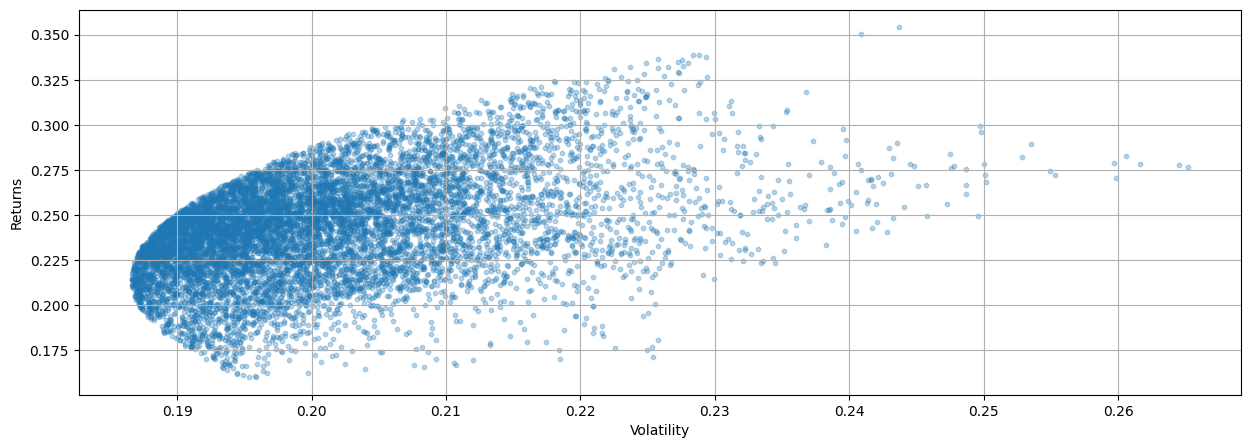

In [12]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[15,5])

Minimum Volatility for the efficient frontier

In [13]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.
min_vol_port

Returns         0.214400
Volatility      0.186616
AAPL weight     0.257787
AMZN weight     0.032577
GOOGL weight    0.288903
NKE weight      0.420732
Name: 8132, dtype: float64

Optimal 'Risky' Portfolio

Maximize the Sharpe ratio for a given risk factor

In [14]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns         0.336240
Volatility      0.225777
AAPL weight     0.755890
AMZN weight     0.196404
GOOGL weight    0.001624
NKE weight      0.046082
Name: 9204, dtype: float64

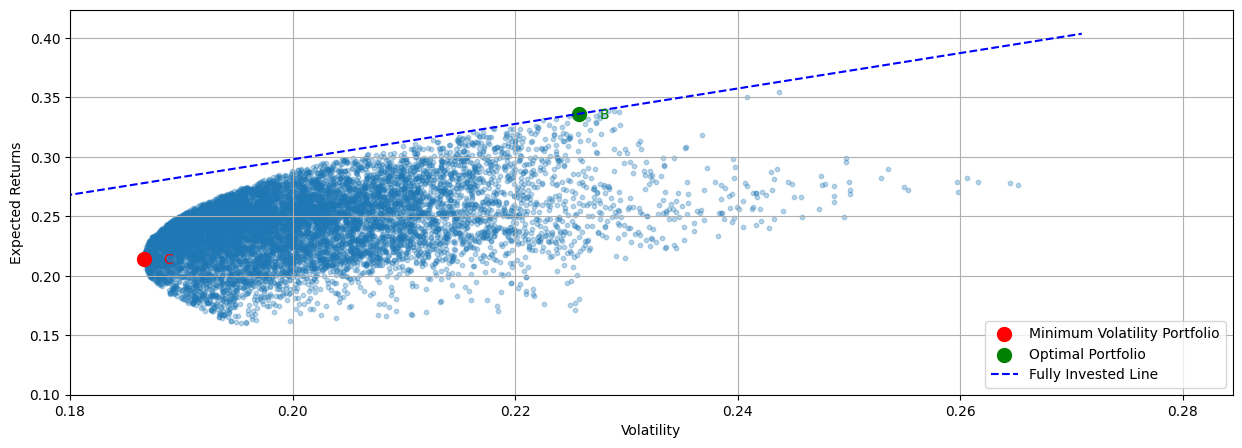

In [15]:
# Plotting optimal portfolio
plt.subplots(figsize=(15, 5))

plt.scatter(portfolios['Volatility'], portfolios['Returns'], marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port.iloc[1], min_vol_port.iloc[0], color='r', marker='o', s=100, label="Minimum Volatility Portfolio")
plt.text(min_vol_port.iloc[1] + 0.0018, min_vol_port.iloc[0] - 0.004, 'C', color='r', fontsize=10)
plt.scatter(optimal_risky_port.iloc[1], optimal_risky_port.iloc[0], color='g', marker='o', s=100, label="Optimal Portfolio")
plt.text(optimal_risky_port.iloc[1] + 0.0018, optimal_risky_port.iloc[0] - 0.004, 'B', color='g', fontsize=10)

# Adding Capital Market Line
cml_x = [0, optimal_risky_port['Volatility'] * 1.2]  # Extend slightly beyond B for better visibility
cml_y = [0, optimal_risky_port['Returns'] * 1.2]
plt.plot(cml_x, cml_y, color='b', linestyle='--', label='Fully Invested Line')

plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.legend(loc='lower right')
plt.xlim(0.18, None)
plt.ylim(0.10, None)
plt.grid(True)

## The Total Return / Total Risk Trade-off

The mean / variance criterion for portfolio choice called _expected_ _utility_

It is denoted as:  $$ \boxed{ U[P] = f_{p} - \lambda_{T} \cdot \sigma_{p}^2 } $$

Where $f_{p}$ is the expected excess return and $\lambda_{T} \cdot \sigma_{p}^2$ is a penalty for the risk.  The parameter $\lambda_{T}$ measures _aversion to total risk_ where total risk includes systematic risk (driven by the benchmarks) and residual risk (from asset selection).

The trick is to find an eligble portfolio with the highest possible utility.

Typical values for $\lambda_{T}$
 - for 3% use $\lambda_{T} = 0.0075$ &emsp; since 3 = 0.0075 . 400
  - for 4% use $\lambda_{T} = 0.01$ &emsp; since 4 = 0.01 . 400


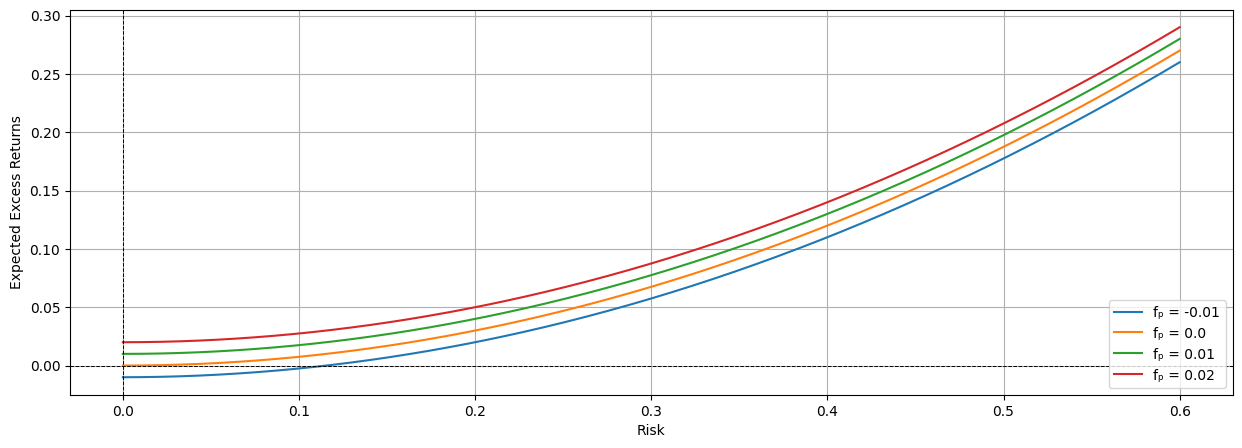

In [16]:
def mu_p(utility_p, lambda_t, sigma_p):
     return utility_p + lambda_t * sigma_p**2

sigma_p = np.linspace(0, 0.6, 500)
utility_levels = [-0.01, 0.00, 0.01, 0.02]

plt.subplots(figsize=(15, 5))
for u in utility_levels:
    plt.plot(sigma_p, mu_p(u,  0.75, sigma_p), label=f'fₚ = {u}')

plt.grid(True)
plt.xlabel("Risk")
plt.ylabel("Expected Excess Returns")
plt.legend(loc='lower right')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
plt.show()